## Introduction

This notebook develops and evaluates machine learning models to predict **claim severity** (the average amount of a claim, given a claim occurred) for AlphaCare Insurance Solutions (ACIS). The objective is to optimize premium pricing by identifying key features influencing claim severity. The analysis uses Linear Regression, Random Forest, and XGBoost models on historical insurance claim data. Additionally, SHAP (SHapley Additive exPlanations) is integrated to interpret model predictions, highlighting the most influential features. A comprehensive comparison of model performance is provided to guide business decisions.

### Setup and Imports

This section configures the Python environment and imports necessary libraries and custom functions for data preparation, model training, evaluation, and SHAP analysis.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
import pandas as pd

from scripts.model_utils import prepare_model_data
from scripts.modeling import (
    split_claim_severity_data,
    train_linear_regression,
    train_random_forest,
    train_xgboost,
    evaluate_model
)
from scripts.classification_models import train_classification_models
from scripts.shap_analysis import run_shap_analysis

### Data Loading and Preparation

The dataset, `MachineLearningRating_v3_cleaned.csv`, contains historical insurance claim data. The `prepare_model_data` function:
- Filters out invalid entries (e.g., non-positive premiums or negative claims).
- Adds derived columns: `has_claim` (binary indicator for claims) and `margin` (premium minus claims).
- Drops uninformative or high-missingness columns (e.g., `PolicyID`, `TransactionMonth`).
- Imputes missing numerical values with means and one-hot encodes categorical variables.

In [2]:
df_raw = pd.read_csv('../data/processed/MachineLearningRating_v3_cleaned.csv', low_memory=False)
df_prepared = prepare_model_data(df_raw)
print(f"Prepared Data Shape: {df_prepared.shape}")

Prepared Data Shape: (618174, 646)


The prepared dataset is suitable for modeling, with cleaned and encoded features.

### Train-Test Split for Claim Severity

For claim severity prediction, only rows with `TotalClaims > 0` are used. The `split_claim_severity_data` function:
- Filters to rows with positive claims.
- Separates features (excluding `TotalClaims`, `has_claim`, `TotalPremium`, `margin`) and the target (`TotalClaims`).
- Splits data into training (80%) and test (20%) sets.

In [3]:
X_train, X_test, y_train, y_test = split_claim_severity_data(df_prepared)

### Model Training

Three regression models are trained to predict claim severity:
- **Linear Regression**: A baseline model assuming linear relationships.
- **Random Forest**: An ensemble model capturing non-linear patterns.
- **XGBoost**: A gradient boosting model for robust predictions.

In [4]:
lr_model = train_linear_regression(X_train, y_train)
rf_model = train_random_forest(X_train, y_train)
xgb_model = train_xgboost(X_train, y_train)

### Model Evaluation

Models are evaluated using **Root Mean Squared Error (RMSE)** and **R² (Explained Variance)** on the test set. Lower RMSE indicates better prediction accuracy, while higher R² indicates better explanation of variance.

In [5]:
lr_results = evaluate_model(lr_model, X_test, y_test)
rf_results = evaluate_model(rf_model, X_test, y_test)
xgb_results = evaluate_model(xgb_model, X_test, y_test)

**Regression Evaluation Results**

| Model             | RMSE          | R² (Explained Variance) |
|-------------------|---------------|-------------------------|
| Linear Regression | 23,236.72     | 0.456                   |
| Random Forest     | 4,798.28      | 0.977 ✅               |
| XGBoost           | 5,890.32      | 0.965                   |

**Regression Interpretation**

- **Linear Regression**: Poor performance (RMSE ~23,237, R² ~0.46), capturing less than half of the variance. Unsuitable for complex insurance data.
- **Random Forest**: Best performance (RMSE ~4,798, R² ~0.977), explaining nearly all variance and providing accurate predictions.
- **XGBoost**: Strong performance (RMSE ~5,890, R² ~0.965), slightly behind Random Forest but still effective.

**Winner**: Random Forest, due to its superior accuracy and variance explanation.

### SHAP Analysis for Model Interpretability

To interpret model predictions and identify key features driving claim severity, SHAP (SHapley Additive exPlanations) is used for the Random Forest and XGBoost models. The `run_shap_analysis` function computes SHAP values and generates bar plots showing the top 10 features by importance.

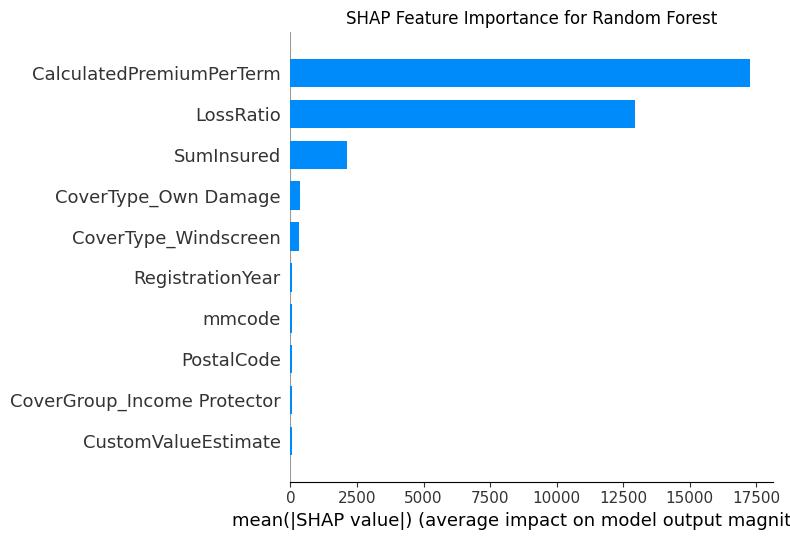

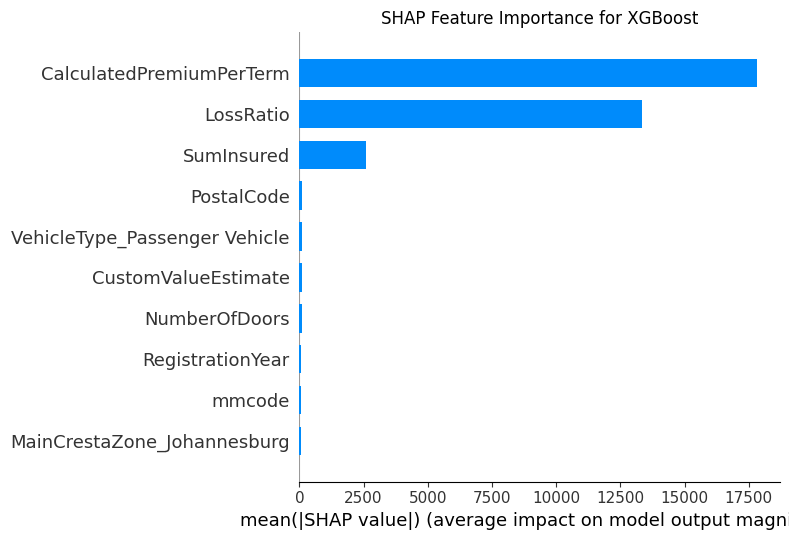

In [6]:
run_shap_analysis(rf_model, xgb_model, X_test)

### SHAP Results Interpretation

- **Random Forest SHAP Plot**: Key features include:
  - `CalculatedPremiumPerTerm`: Highest impact (~17,500 mean|SHAP|), reflecting premium levels strongly influence severity.
  - `LossRatio`: Significant (~12,500 mean|SHAP|), indicating claims-to-premium ratio drives predictions.
  - `SumInsured`: Moderate (~5,000 mean|SHAP|), tied to insured value.
  - Lower impacts from `CoverType_Own Damage`, `CoverType_Windscreen`, `RegistrationYear`, `mmcode`, `PostalCode`, `CoverGroup_Income Protector`, and `CustomValueEstimate`.
- **XGBoost SHAP Plot**: Key features include:
  - `CalculatedPremiumPerTerm`: Highest (~17,500 mean|SHAP|), consistent with Random Forest.
  - `LossRatio`: Strong (~12,500 mean|SHAP|), aligning with Random Forest findings.
  - `SumInsured`: Moderate (~5,000 mean|SHAP|).
  - Additional features: `PostalCode`, `VehicleType_Passenger Vehicle`, `CustomValueEstimate`, `NumberOfDoors`, `RegistrationYear`, `mmcode`, and `MainCrestaZone_Johannesburg` show lower but notable impacts.
- **Key Insights**:
  - **Premium and Loss Metrics**: `CalculatedPremiumPerTerm` and `LossRatio` are top drivers, suggesting pricing and claim frequency strongly affect severity.
  - **Insured Value**: `SumInsured` reflects higher claim costs for valuable assets.
  - **Location and Vehicle Type**: `PostalCode`, `MainCrestaZone_Johannesburg`, and `VehicleType_Passenger Vehicle` indicate regional and vehicle-specific risks.
  - **Minor Factors**: `CoverType` variants and `RegistrationYear` have limited impact, while owner-related features (e.g., `Gender`) remain negligible.

### Classification Model Results

For completeness, classification models predict the likelihood of a claim occurring (`has_claim`). Results are obtained from the `train_classification_models` function.

In [7]:
results, models, X_test, y_test = train_classification_models(df_prepared)
pd.DataFrame(results)

,Logistic Regression,Random Forest,XGBoost
Accuracy,0.999523,0.99996,0.999976
Precision,0.994264,1.0,1.0
Recall,0.902778,0.991319,0.994792
F1-Score,0.946315,0.995641,0.997389
ROC-AUC,0.998222,1.0,0.999046
ConfusionMatrix,"[[123056, 3], [56, 520]]","[[123059, 0], [5, 571]]","[[123059, 0], [3, 573]]"
ClassificationReport,"{'0.0': {'precision': 0.9995451296380532, 'rec...","{'0.0': {'precision': 0.999959370733927, 'reca...","{'0.0': {'precision': 0.9999756220441729, 'rec..."


### Classification Interpretation

- **XGBoost**: Best (F1-Score 0.997, ROC-AUC 0.999), high recall for claim detection.
- **Random Forest**: Excellent (F1-Score 0.996, ROC-AUC 1.0), close to XGBoost.
- **Logistic Regression**: Decent but weaker (F1-Score 0.946).

**Winner**: XGBoost.

## Final Model Comparison and Recommendations

### Model Performance Summary

| Task                | Model             | Key Metrics                          | Notes                                                                 |
|---------------------|-------------------|--------------------------------------|----------------------------------------------------------------------|
| **Claim Severity (Regression)** | Random Forest     | RMSE: 4,798.28, R²: 0.977           | Best performer; excels with premium and loss metrics.                |
|                     | XGBoost           | RMSE: 5,890.32, R²: 0.965           | Strong alternative; consistent feature importance.                   |
|                     | Linear Regression | RMSE: 23,236.72, R²: 0.456         | Poor fit for complex data.                                           |
| **Claim Occurrence (Classification)** | XGBoost           | F1-Score: 0.997, ROC-AUC: 0.999     | Best for claim likelihood; high recall critical.                     |
|                     | Random Forest     | F1-Score: 0.996, ROC-AUC: 1.0       | Very close to XGBoost; robust performance.                           |
|                     | Logistic Regression | F1-Score: 0.946, ROC-AUC: 0.998   | Outperformed by tree-based models.                                   |

### SHAP-Based Insights

- **Top Drivers**: `CalculatedPremiumPerTerm` and `LossRatio` dominate, indicating premium levels and claim ratios are critical for severity.
- **Insured Value**: `SumInsured` reflects higher costs for valuable vehicles.
- **Regional Risk**: `PostalCode` and `MainCrestaZone_Johannesburg` suggest location-based risk variations.
- **Vehicle Factors**: `VehicleType_Passenger Vehicle` and `NumberOfDoors` have minor but consistent impacts.
- **Consistency**: Both models agree on key features, enhancing reliability.

### Business Recommendations

1. **Adopt Random Forest for Severity**:
   - Use for premium pricing, leveraging `CalculatedPremiumPerTerm` and `LossRatio` insights.
   - Adjust premiums based on `SumInsured` and regional risks (e.g., higher in Johannesburg).
2. **Use XGBoost for Occurrence**:
   - Target high-risk clients using its superior recall for claim prediction.
3. **Premium Optimization**:
   - Refine premiums using `CalculatedPremiumPerTerm` and `LossRatio` to balance profitability and competitiveness.
4. **Regional Segmentation**:
   - Increase premiums in high-risk areas like Johannesburg (`MainCrestaZone_Johannesburg`) and offer discounts elsewhere.
5. **Vehicle-Based Adjustments**:
   - Consider `SumInsured` and `VehicleType` for tailored pricing (e.g., lower rates for passenger vehicles with fewer doors).
6. **Continuous Monitoring**:
   - Retrain with new data to track evolving risks.
   - Explore additional features (e.g., driver history) for enhanced accuracy.

### Next Steps

- **Deploy Models**: Integrate Random Forest (severity) and XGBoost (occurrence) into ACIS systems.
- **Deep Dive on Features**: Analyze specific `PostalCode` or `MainCrestaZone` values for finer segmentation.
- **Expand Data**: Include driver behavior data to improve predictions.
- **Performance Tracking**: Monitor model outputs against real claims post-deployment.

This analysis provides ACIS with interpretable, actionable insights for optimized pricing and risk management.